<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/sbi_lens/blob/u%2FJustinezgh%2Fcompressor/notebooks/train_compressor_LensingLogNormal_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Overview** 

The goal of this notebook is to train our compressor (ResNet 18) to extract non-Gaussian signal from [simulated log-normal mass maps](https://github.com/DifferentiableUniverseInitiative/sbi_lens/blob/main/sbi_lens/simulator/LogNormal_field.py). If the mass map compression is optimal, we expect to obtain the same contours as those obtained performing full field inference:

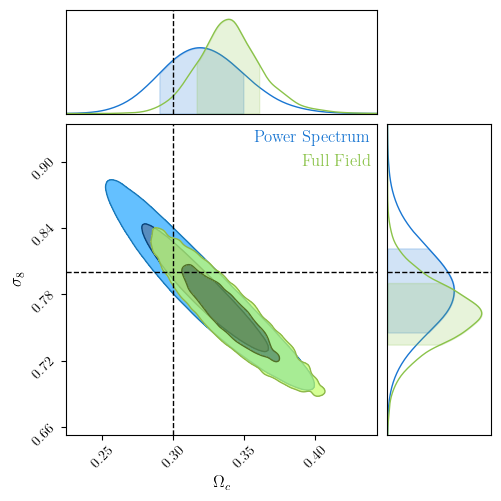

We approximate the green contours by $p(\Omega_c, \sigma_8 | x = (x_1,x_2))$ with $(x_1,x_2)$ the summary statistics from the compressor doing Simulation-Based Inference, in particular we do Neural Posterior Estimation using Normalizing Flow.

# Imports

In [1]:
!pip install --quiet jax==0.3.25
!pip install --quiet dm-haiku==0.0.5
!pip install --quiet optax==0.1.4
!pip install --quiet flax==0.6.3
!pip install --quiet chainconsumer
!pip install --quiet numpyro==0.10.1
!pip install --quiet jax-cosmo===0.1rc9
!pip install --quiet lenstools==1.2
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/sbi_lens@u/Justinezgh/get_true_posterior

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.3/287.3 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
%pylab inline
from functools import partial
from tqdm import tqdm
import pickle
from chainconsumer import ChainConsumer

import jax
import jax.numpy as jnp

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions
tfb = tfp.bijectors

import tensorflow_datasets as tfds
import tensorflow as tf

import haiku as hk
from haiku._src.nets.resnet import ResNet18
import optax
from flax.metrics import tensorboard

from sbi_lens.normflow.models import AffineSigmoidCoupling, ConditionalRealNVP
from sbi_lens.gen_dataset.lensing_lognormal_dataset import LensingLogNormalDataset

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/usr/local/lib/python3.8/dist-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)


In [4]:
%load_ext autoreload
%autoreload 2

# Dataset

In [11]:
# load and create dataset
ds = tfds.load(
    'LensingLogNormalDataset/toy_model_without_noise_score_density', 
    split='train', 
    data_dir = 'tensorflow_dataset'
)

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.8/dist-packages/jax_cosmo/scipy/interpolate.py:35: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  s = np.sign(np.clip(x, xp[1], xp[-2]) - xi).astype(np.int64)
/usr/local/lib/python3.8/dist-packages/jax_cosmo/scipy/interpolate.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  a = (fp[ind + np.copysign(1, s).astype(np.int64)] - fp[ind]) / (
/usr/local/lib/python3.8/dist-packages/jax_cosmo/scipy/interpolate.py:37: UserWarnin

Shuffling tensorflow_dataset/lensing_log_normal_dataset/toy_model_without_noise_score_density/0.0.1.incomplete…

Dataset lensing_log_normal_dataset downloaded and prepared to tensorflow_dataset/lensing_log_normal_dataset/toy_model_without_noise_score_density/0.0.1. Subsequent calls will reuse this data.


In [12]:
tf.random.set_seed(1)
                           
def augmentation_with_noise(example):

      N=128
      map_size=5
      gal_per_arcmin2=30
      sigma_e=0.2
      pix_area = (map_size * 60 / N)**2  

      ex = tf.expand_dims(example['simulation'], axis = -1)
      noise = tf.random.normal(
          shape=(N, N, 1), 
          stddev=sigma_e/tf.math.sqrt(gal_per_arcmin2 * pix_area)
      )
      x = ex + noise
      x = tf.image.random_flip_left_right(x)
      x = tf.image.random_flip_up_down(x)

      return {'simulation': x, 'theta': example['theta'], 'score': example['score']}

# Compressor

We train our compressor $F_{\varphi}$ ( which takes as input a mass map and returns 2 summary statistics: $F_{\varphi}(\text{mass map}) = (x_1, x_2)$ ) by maximizing [mutual information](https://arxiv.org/pdf/2009.08459.pdf) $I$: 

$$\varphi∗ = \text{arg max } I(F_{\varphi}(\text{mass map}), (\Omega_c, \sigma_8)) $$



## Build compressor

In [34]:
# create nf to train using mutual information
bijector_layers_compressor = [128] * 2

bijector_compressor = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers_compressor, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_compressor = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_compressor
)

class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(2)(y)
        return nvp

nf = hk.without_apply_rng(hk.transform(lambda theta, y : Flow_nd_Compressor()(y).log_prob(theta).squeeze()))
params_nf = nf.init(jax.random.PRNGKey(8),  0.5*jnp.ones([1,2]), 0.5*jnp.ones([1,2]))

# ResNet 18
compressor = hk.transform_with_state(lambda x : ResNet18(2)(x, is_training=True))
parameters_resnet, opt_state_resnet  = compressor.init(jax.random.PRNGKey(873457568), 0.5*jnp.ones([1,128,128,1]))

parameters_compressor = hk.data_structures.merge(parameters_resnet, params_nf)

/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


## Training

In [35]:
def loss_vmim(params, mu, batch, state_resnet):
  y, opt_state_resnet = compressor.apply(
      params, state_resnet, None, batch.reshape([-1,128,128,1])
  )
  log_prob = jax.vmap(
      lambda theta, x: nf.apply(
          params, 
          theta.reshape([1,2]), 
          x.reshape([1,2])
      ).squeeze()
  )(mu, y)
  return -jnp.mean(log_prob) , opt_state_resnet

@jax.jit
def update_compressor_with_vmim(params, opt_state, mu, batch, state_resnet):
    """Single SGD update step."""
    (loss, opt_state_resnet), grads = jax.value_and_grad(
        loss_vmim, 
        has_aux = True
    )(params, mu, batch, state_resnet)
    updates, new_opt_state = optimizer_c.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state, opt_state_resnet

In [ ]:
# dataset
ds = tfds.load('LensingLogNormalDataset/toy_model_without_noise_score_density', 
               split='train[:80000]', 
               data_dir = 'tensorflow_dataset')

ds = ds.repeat()
ds = ds.shuffle(1000)
ds = ds.map(augmentation_with_noise)
ds = ds.batch(128)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds))

total_steps = 100000 # usually 200000
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={int(total_steps*0.1):0.7,
                           int(total_steps*0.2):0.7,
                           int(total_steps*0.3):0.7,
                           int(total_steps*0.4):0.7,
                           int(total_steps*0.5):0.7,
                           int(total_steps*0.6):0.7,
                           int(total_steps*0.7):0.7,
                           int(total_steps*0.8):0.7,
                           int(total_steps*0.9):0.7}
)

optimizer_c = optax.adam(learning_rate=lr_scheduler)
opt_state_c = optimizer_c.init(parameters_compressor)
batch_loss=[]
for batch in tqdm(range(total_steps)):
    sample = next(ds_train)
    l, parameters_compressor, opt_state_c, opt_state_resnet = update_compressor_with_vmim(
        parameters_compressor,
        opt_state_c, 
        sample['theta'],
        sample['simulation'], 
        opt_state_resnet
    )

    if batch % 100 == 0:
        batch_loss.append(l)

  0%|          | 0/100000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
/usr/local/lib/python3.8/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
 35%|███▍      | 34981/100000 [1:14:20<2:14:33,  8.05it/s]

In [ ]:
plt.plot(batch_loss[10:])

In [ ]:
import pickle
with open("params_nd_compressor.pkl", "wb") as fp:
  pickle.dump(parameters_compressor, fp)

with open("opt_state_resnet.pkl", "wb") as fp:
  pickle.dump(opt_state_resnet, fp)

# SBI

## Create NF for SBI

In [ ]:
bijector_layers = [128] * 2

bijector_npe = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_npe = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_npe
)

prior = tfd.MultivariateNormalDiag(jnp.array([0.3,0.8]), 0.05*jnp.ones(2))
theta = prior.sample(10000,jax.random.PRNGKey(0))
scale_theta = (jnp.std(theta, axis = 0)/0.06)
shift_theta = jnp.mean(theta/scale_theta, axis = 0)-0.5

class SmoothNPE(hk.Module):
    def __call__(self, y):
        net = y
        nvp = NF_npe(2)(net)
        nf = tfd.TransformedDistribution(
            nvp,
            tfb.Chain([tfb.Scale(scale_theta),tfb.Shift(shift_theta)])
        )
        return nf

nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).log_prob(theta).squeeze()))
params_nd = nvp_nd.init(jax.random.PRNGKey(42), 0.5*jnp.ones([1,2]), 0.5*jnp.ones([1,2]))

## Training

In [ ]:
# define loss function and model update
def loss_fn(params, parameters_compressor, opt_state_resnet, weight, mu, batch, score):

  y, _ = compressor.apply(parameters_compressor, opt_state_resnet, None, batch.reshape([-1,128,128,1]))
  
  log_prob, out = jax.vmap(
    jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,2]), x.reshape([1,2])).squeeze())
    )(mu, y)

  nll = - jnp.mean(log_prob)
  sm = jnp.mean(jnp.sum((out - score)**2, axis=1))
      
  return nll + weight * sm

@jax.jit
def update(params, parameters_compressor, opt_state, opt_state_resnet, weight, mu, batch, score):
    """Single SGD update step."""
    loss, grads  = jax.value_and_grad(loss_fn)(
        params,
        parameters_compressor, 
        opt_state_resnet, 
        weight, 
        mu,
        batch, 
        score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [ ]:
score_weight = 0

ds = tfds.load('LensingLogNormalDataset/toy_model_without_noise_score_density', 
               split='train[80000:]', 
               data_dir = 'tensorflow_dataset')

ds = ds.repeat()
ds = ds.shuffle(1000)
ds = ds.map(augmentation_with_noise)
ds = ds.batch(128)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds))

#optimizer
total_steps = 50000
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={int(total_steps*0.2):0.7,
                           int(total_steps*0.4):0.7,
                           int(total_steps*0.6):0.7,
                           int(total_steps*0.8):0.7}
)

optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state = optimizer.init(params_nd)

batch_loss=[]
for batch in tqdm(range(total_steps)):
    samples = next(ds_train)
    l, params_nd, opt_state = update(
        params_nd, 
        parameters_compressor, 
        opt_state, 
        opt_state_resnet,
        score_weight, 
        samples['theta'], 
        samples['simulation'], 
        samples['score']
    )

    if batch % 100 == 0:
        batch_loss.append(l)

In [ ]:
plt.plot(batch_loss)

## Create fiducial and plot results

In [ ]:
from sbi_lens.simulator.utils import get_reference_sample_posterior_full_field, get_reference_sample_posterior_power_spectrum, get_samples_and_scores

In [ ]:
samples_ps, m_data, truth = get_reference_sample_posterior_power_spectrum()
samples_ff, _, _ = get_reference_sample_posterior_full_field()

In [ ]:
imshow(m_data)

In [ ]:
y, _ = compressor.apply(
    parameters_compressor, opt_state_resnet, None, m_data.reshape([1,128,128,1])
)
nvp_sample_nd = hk.transform(
    lambda x : SmoothNPE()(x).sample(len(samples_ps), seed=hk.next_rng_key())
)
sample_nd = nvp_sample_nd.apply(
    params_nd, 
    rng = jax.random.PRNGKey(43), 
    x = y*jnp.ones([len(samples_ps),2])
)


c = ChainConsumer()
c.add_chain(samples_ps, parameters=["$\Omega_c$", "$\sigma_8$"], name='Power Spectrum')
c.add_chain(samples_ff, parameters=["$\Omega_c$", "$\sigma_8$"], name='Full Field')
c.add_chain(sample_nd, parameters=["$\Omega_c$", "$\sigma_8$"], name='SBI')
fig = c.plotter.plot(figsize="column", truth = [0.3,0.8])